In [1]:
# import drive
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split

from skimage import io, color
from PIL import Image
import cv2

import os
import random

import torch
from torch.utils.data  import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models

from google.colab import drive

print(torch.__version__)

2.6.0+cu124


# **Mask Generation**
Done only once and replaced that  annotation with masks permanently
Did not changed the annotation file name though

In [ ]:
#train_pixel = pd.read_csv('/content/drive/MyDrive/mlmed2025/HC18/training_set_pixel_size_and_HC.csv')
#train_pixel

In [ ]:
# def masking(image):
#     imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     ret, thresh = cv2.threshold(imgray, 127, 255, 0)

#     contours, useless1 = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#     ellipse = cv2.fitEllipse(contours[0])
#     return cv2.ellipse(image, ellipse, (255,255,255), -1)


In [ ]:
# for index in range(len(train_pixel)):
#     file_path = os.path.join('/content/drive','MyDrive','mlmed2025','HC18','training_set', train_pixel.iloc[index, 0].replace('.png','_Annotation.png'))
#     image = cv2.imread(file_path)
#     if image is None:
#         print(f"Error: Could not load image at {file_path}")
#         continue
#     mask = masking(image)
#     cv2.imwrite(file_path, mask)

#**Traning**


In [ ]:
class HC18(Dataset):
    """Train and validation dataset class"""
    def __init__(self, root_dir, train=True, transformX=None, transformY=None):
        self.pixel_file = pd.read_csv(os.path.join(root_dir, 'training_set_pixel_size_and_HC.csv'))
        self.root_dir = root_dir
        self.transformX = transformX
        self.transformY = transformY
        self.train = train

        self.train_data, self.validation_data = train_test_split(self.pixel_file, test_size=0.1, random_state=5)

    def __len__(self):
        if self.train:
            return len(self.train_data)
        else:
            return len(self.validation_data)

    def __getitem__(self, index):
        if self.train:
            imx_name = os.path.join(self.root_dir, 'training_set', self.train_data.iloc[index, 0])
            imy_name = os.path.join(self.root_dir, 'training_set', self.train_data.iloc[index, 0].replace('.png', '_Annotation.png'))
        else:
            imx_name = os.path.join(self.root_dir, 'training_set', self.validation_data.iloc[index, 0])
            imy_name = os.path.join(self.root_dir, 'training_set', self.validation_data.iloc[index, 0].replace('.png', '_Annotation.png'))

        imx = Image.open(imx_name)
        imy = Image.open(imy_name).convert('L')

        # augmentation
        if self.train:
            # horizontal flipping
            if random.random() > 0.5:
                imx = TF.hflip(imx)
                imy = TF.hflip(imy)

            # vertical flipping
            if random.random() > 0.5:
                imx = TF.vflip(imx)
                imy = TF.vflip(imy)

            # rotation
            if random.random() > 0.8:
                angle = random.choice([-30, -90, -60, -45, -15, 0, 15, 30, 45, 60, 90])
                imx = TF.rotate(imx, angle)
                imy = TF.rotate(imy, angle)

        if self.transformX:
            imx = self.transformX(imx)
            imy = self.transformY(imy)

        sample = {'image': imx, 'annotation': imy}
        return sample

In [ ]:
tx_X = transforms.Compose([ transforms.Resize((572, 572)),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))
                              ])
tx_Y = transforms.Compose([ transforms.Resize((572, 572)),
                              transforms.ToTensor(),
                              ])
train_data = HC18('/content/drive/MyDrive/mlmed2025/HC18', train = True, transformX = tx_X, transformY = tx_Y)
validation_data = HC18('/content/drive/MyDrive/mlmed2025/HC18', train = False, transformX = tx_X, transformY = tx_Y )

In [ ]:
train_loader = DataLoader(dataset = train_data, batch_size = 8, shuffle = True, num_workers = 2 )
validation_loader = DataLoader(dataset = validation_data, batch_size = 8, shuffle = True, num_workers = 2)

In [ ]:
def im_converterX(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1,2,0)
 # print(image.shape)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

In [ ]:
# fig = plt.figure(figsize = (15,6))
# for ith_batch, sample_batched in enumerate(train_loader):
#     print(ith_batch, sample_batched['image'].size(), sample_batched['annotation'].size())

#     for index in range(2):
#         ax = fig.add_subplot(2, 2 , index + 1)  # subplot index starts from 1
#         plt.imshow(im_converterX(sample_batched['image'][index]))
#         ax = fig.add_subplot(2, 2, index + 3)
#         plt.imshow(im_converterY(sample_batched['annotation'][index]))
#     break

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_rate=0.1):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        if g.size()[2:] != x.size()[2:]:
            g = F.interpolate(g, size=x.size()[2:], mode='bilinear', align_corners=True)
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        if g1.size()[2:] != x1.size()[2:]:
            g1 = F.interpolate(g1, size=x1.size()[2:], mode='bilinear', align_corners=True)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        if psi.size()[2:] != x.size()[2:]:
            psi = F.interpolate(psi, size=x.size()[2:], mode='bilinear', align_corners=True)
        return x * psi

class Up(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch, bilinear=True):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch, in_ch, 2, stride=2)

        self.att = AttentionGate(F_g=in_ch, F_l=skip_ch, F_int=skip_ch//2)
        # Input to DoubleConv will be in_ch + skip_ch after concatenation
        self.conv = DoubleConv(in_ch + skip_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))

        x2 = self.att(x1, x2)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#!pip install efficientnet_pytorch

In [ ]:
from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.utils import url_map, url_map_advprop, get_model_params
from torchvision.models import efficientnet_b3
from torchvision.models.efficientnet import EfficientNet_B3_Weights

In [ ]:
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

class EfficientNetUNet(nn.Module):
    def __init__(self, n_channels, n_classes, device):
        super(EfficientNetUNet, self).__init__()
        self.device = device

        self.efficientnet = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)
        self.efficientnet = self.efficientnet.to(device)

        for name, param in self.efficientnet.named_parameters():
            if "features.0" in name or "features.1" in name or "features.2" in name:
                param.requires_grad = False
            else:
                param.requires_grad = True

        self.encoder = self.efficientnet.features.to(device)
        self.encoder[0][0] = nn.Conv2d(n_channels, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False).to(device)

        self.decoder_initialized = False
        self.up1 = None
        self.up2 = None
        self.up3 = None
        self.up4 = None
        self.outc = None

    def initialize_decoder(self, feature_maps):
        dims = [fm.size(1) for fm in feature_maps]
        self.up1 = Up(dims[-1], dims[-2], dims[-2]).to(self.device)
        self.up2 = Up(dims[-2], dims[-3], dims[-3]).to(self.device)
        self.up3 = Up(dims[-3], dims[-4], dims[-4]).to(self.device)
        self.up4 = Up(dims[-4], dims[-5], 64).to(self.device)
        self.outc = OutConv(64, 1).to(self.device)
        self.decoder_initialized = True

    def forward(self, x):
        x = x.float()
        input_size = x.size()[2:]

        feature_maps = []
        for layer in self.encoder:
            x = layer(x)
            feature_maps.append(x)

        if not self.decoder_initialized:
            self.initialize_decoder(feature_maps)

        x = self.up1(feature_maps[-1], feature_maps[-2])
        x = self.up2(x, feature_maps[-3])
        x = self.up3(x, feature_maps[-4])
        x = self.up4(x, feature_maps[-5])
        x = self.outc(x)

        x = F.interpolate(x, size=input_size, mode='bilinear', align_corners=False)
        return torch.sigmoid(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EfficientNetUNet(1, 1, device)
model = model.to(device)
print("Model Loaded to", "GPU" if torch.cuda.is_available() else "CPU")

Model Loaded to GPU


In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.007, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [ ]:
# calculates similarity index between predicted and actual segmentation
def dice_index(y_pred, y_actual):
    smooth = 0.00001
    size_of_batch = y_pred.size(0)

    p1 = y_pred.view(size_of_batch, -1)
    p2 = y_actual.view(size_of_batch, -1)

    intersection = (p1 * p2).sum()

    dice =  ((2.0 * intersection )+ smooth) / (p1.sum() + p2.sum() + smooth)

    return dice

In [ ]:
def dice_loss(y_predict, y_train):

  dice_loss = 1 -(dice_index(y_predict, y_train))

  return dice_loss

In [ ]:
import torch
import torch.nn as nn
import os

def save_checkpoint(model, optimizer, scheduler, epoch, train_loss_history, val_loss_history, filepath):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'lr': optimizer.param_groups[0]['lr'],
        'train_loss_history': train_loss_history,
        'validation_loss_history': val_loss_history
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved at epoch {epoch}")

def load_checkpoint(filepath, model, optimizer, scheduler):
    if os.path.exists(filepath):
        checkpoint = torch.load(filepath)

        with torch.no_grad():
            dummy_input = torch.randn(1, 1, 572, 572).to(device)
            model(dummy_input)

        model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        print("Model state loaded with strict=False due to possible architecture changes.")

        lr = checkpoint.get('lr', 0.007)
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
        print("Optimizer reinitialized with lr from checkpoint or default.")

        if 'scheduler_state_dict' in checkpoint:
            try:
                scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
                print("Scheduler state loaded successfully.")
            except Exception as e:
                print(f"Failed to load scheduler state: {e}. Using default scheduler.")

        epoch = checkpoint.get('epoch', 0)
        train_loss_history = checkpoint.get('train_loss_history', [])
        validation_loss_history = checkpoint.get('validation_loss_history', [])
        print(f"Checkpoint loaded from epoch {epoch}")
        return epoch, train_loss_history, validation_loss_history, optimizer, scheduler
    else:
        print("No checkpoint found, starting from scratch.")
        return 0, [], [], optimizer, scheduler

epochs = 50
checkpoint_filepath = '/content/drive/MyDrive/mlmed2025/HC18/checkpoint.pth'
train_running_loss_history = []
validation_running_loss_history = []

start_epoch, train_running_loss_history, validation_running_loss_history, optimizer, scheduler = load_checkpoint(
    checkpoint_filepath, model, optimizer, scheduler
)

for e in range(start_epoch, epochs):
    train_running_loss = 0.0
    validation_running_loss = 0.0

    model.train()
    for ith_batch, sample_batched in enumerate(train_loader):
        X_train = sample_batched['image'].to(device)
        y_train = sample_batched['annotation'].to(device)

        optimizer.zero_grad()
        y_pred = model(X_train)

        loss = 0.50 * dice_loss(y_pred, y_train) + 0.50 * criterion(y_pred, y_train)

        loss.backward()
        optimizer.step()

        if ith_batch % 50 == 0:
            print(f'Epoch: {e + 1}, Batch: {ith_batch}, Current Loss: {loss.item()}')

        train_running_loss += loss.item()

    with torch.no_grad():
        model.eval()
        for ith_batch, sample_batched in enumerate(validation_loader):
            X_val = sample_batched['image'].to(device)
            y_val = sample_batched['annotation'].to(device)

            y_out = model(X_val)
            out_val = (y_out + 0.5).int().float()

            val_loss = 0.50 * dice_loss(out_val, y_val) + 0.50 * criterion(y_out, y_val)
            validation_running_loss += val_loss.item()

        print("=" * 80)
        print(f"Epoch {e + 1} completed")
        train_epoch_loss = train_running_loss / len(train_loader)
        validation_epoch_loss = validation_running_loss / len(validation_loader)

        print(f"Average train loss: {train_epoch_loss}")
        print(f"Average validation loss: {validation_epoch_loss}")
        print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
        print("=" * 80)

        train_running_loss_history.append(train_epoch_loss)
        validation_running_loss_history.append(validation_epoch_loss)

        scheduler.step(validation_epoch_loss)

    save_checkpoint(model, optimizer, scheduler, e + 1, train_running_loss_history, validation_running_loss_history, checkpoint_filepath)
    torch.cuda.empty_cache()

No checkpoint found, starting from scratch.
Epoch: 1, Batch: 0, Current Loss: 0.6597223281860352
Epoch: 1, Batch: 50, Current Loss: 0.34363019466400146
Epoch: 1, Batch: 100, Current Loss: 0.3670693039894104
Epoch 1 completed
Average train loss: 0.3692956825273227
Average validation loss: 0.18839246607743776
Current learning rate: 0.007
Checkpoint saved at epoch 1
Epoch: 2, Batch: 0, Current Loss: 0.33331066370010376
Epoch: 2, Batch: 50, Current Loss: 0.33440297842025757
Epoch: 2, Batch: 100, Current Loss: 0.30132240056991577
Epoch 2 completed
Average train loss: 0.311185720747551
Average validation loss: 0.159285130409094
Current learning rate: 0.007
Checkpoint saved at epoch 2
Epoch: 3, Batch: 0, Current Loss: 0.29049113392829895
Epoch: 3, Batch: 50, Current Loss: 0.31158411502838135
Epoch: 3, Batch: 100, Current Loss: 0.31953051686286926
Epoch 3 completed
Average train loss: 0.2966048638377569
Average validation loss: 0.1505759025995548
Current learning rate: 0.007
Checkpoint saved a

KeyboardInterrupt: 

In [ ]:
model.eval()
X_train.size()
y_train.size()

In [ ]:
out = (y_pred + 0.5).int().float()

In [ ]:
print(dice_index(y_train, out))
print(dice_loss(y_train, out))

In [ ]:
def im_converterY(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1,2,0)
    image = image.squeeze() # Remove channel dimension
    return image

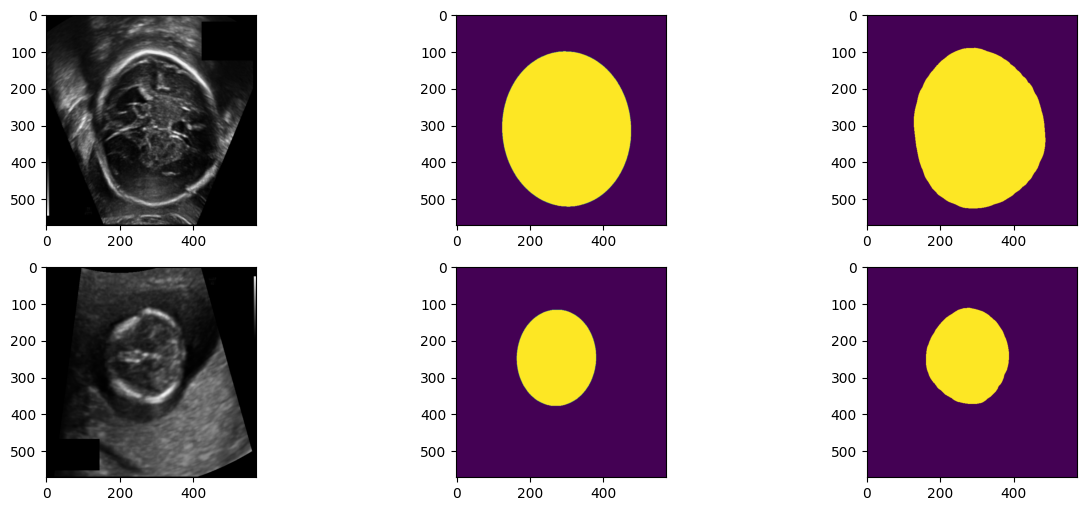

In [ ]:
pig = plt.figure(figsize = (15, 6))

out = (y_pred + 0.5).int().float()

a = pig.add_subplot(2, 3, 1)
plt.imshow(im_converterX(X_train[0]))

a = pig.add_subplot(2, 3, 2)
plt.imshow(im_converterY(y_train[0]))

a = pig.add_subplot(2, 3, 3)
plt.imshow(im_converterY(out[0]))


a = pig.add_subplot(2, 3, 4)
plt.imshow(im_converterX(X_train[1]))

a = pig.add_subplot(2, 3, 5)
plt.imshow(im_converterY(y_train[1]))

a = pig.add_subplot(2, 3, 6)
plt.imshow(im_converterY(out[1]))

In [ ]:
gg = dice_index(out, y_train)
print(gg)
print(dice_loss(out, y_train))

In [ ]:
class HC18_test(Dataset):
    def __init__(self, root_dir, transformX = None):
        self.pixel_file = pd.read_csv(os.path.join(root_dir, 'test_set_pixel_size.csv'))
        self.root_dir = root_dir
        self.transformX = transformX

    def __len__(self):
        return len(self.pixel_file)

    def __getitem__(self, index):
        imx_name = os.path.join(self.root_dir, 'test_set', self.pixel_file.iloc[index, 0])

        imx = Image.open(imx_name)

        f_name = self.pixel_file.iloc[index, 0]

        if self.transformX :
            imx = self.transformX(imx)

        sample = {'image': imx, 'f_name': f_name}
        return sample

In [ ]:
test_data = HC18_test('/content/drive/MyDrive/mlmed2025/HC18', transformX = tx_X)

In [ ]:
test_loader = DataLoader(dataset = test_data, batch_size = 8, shuffle = True)

0 torch.Size([8, 1, 572, 572])


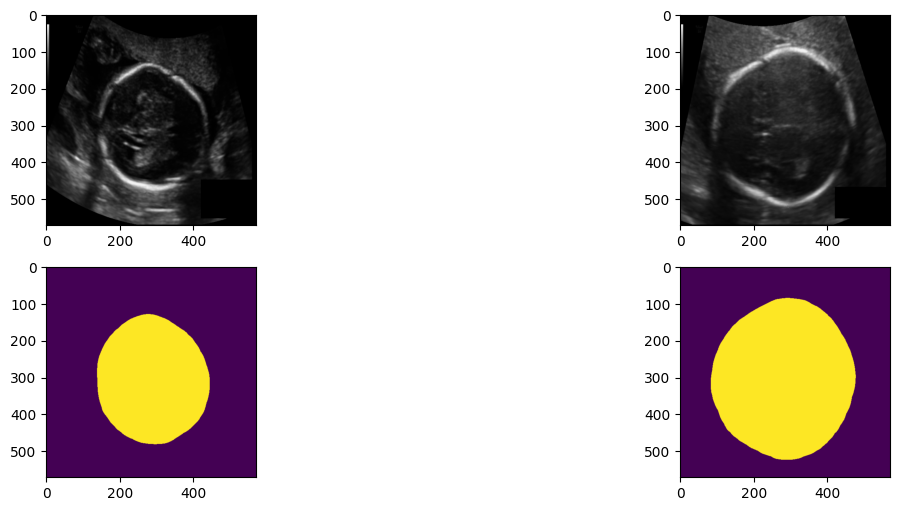

In [ ]:
fig = plt.figure(figsize = (15,6))
#model.to('cpu')
for ith_batch, sample_batched in enumerate(test_loader):

    X_test = sample_batched['image'].to('cuda')
    print(ith_batch, X_test.size())

    y_test = (model(X_test) + 0.5).int().float()



    for index in range(2):
        ax = fig.add_subplot(2, 2 , index + 1)
        plt.imshow(im_converterX(X_test[index]))

        ax  = fig.add_subplot(2, 2, index + 3)
        plt.imshow(im_converterY(y_test[index]))
    break

In [ ]:
def avg_dice_index(dataloader):

    dice = 0.0
    model.eval()
    with torch.no_grad():

        for ith_batch, sample_batched in enumerate(dataloader):

            X_train = sample_batched['image'].to('cuda')
            y_train = sample_batched['annotation'].to('cuda')

            y_predict = (model(X_train) + 0.5).int().float()

            dice += dice_index(y_predict, y_train)



    avg_dice = dice / len(dataloader)
    return avg_dice.item()

In [ ]:
avg_dice_index(train_loader)

0.9708805084228516

In [ ]:
avg_dice_index(validation_loader)

0.9698571562767029

In [ ]:
avg_dice_index(test_loader)

KeyError: 'annotation'

## **Warning!!!**
### Your are about to write on drive

In [ ]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((540, 800)),
        transforms.ToTensor()
        ])

with torch.no_grad():
      #model.eval()
      for ith_batch , sample in enumerate(test_loader):
        X_test = sample['image'].to('cuda')
        y_pred = (model(X_test) + 0.5).int().float().cpu()
       # print(335-ith_batch)

        file_names = sample['f_name']
        pankaj = transform(y_pred[0])
        #singh = transform(y_pred[1])
        torchvision.utils.save_image(pankaj , os.path.join('/content/drive/MyDrive/mlmed2025/HC18/segmented', file_names[0]))
        #torchvision.utils.save_image(singh, os.path.join('/content/drive/MyDrive/mlmed2025/HC18/test_set', file_names[1].replace('.png','_Annotation.png')))
      print("Segmentation files written")



Segmentation files written


In [ ]:
import numpy as np
import cv2

def fit_ellipse(im):
    """
    Fits an ellipse to the largest contour in the image.

    Args:
        im: The input image.

    Returns:
        ellipse: The fitted ellipse parameters (center, axes, angle).
                Returns None if no contours are found.
    """
    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 127, 255, 0)


    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print("Warning: No contours found in the image.")
        return None

    contour_sizes = [len(contour) for contour in contours]
    ellipse = cv2.fitEllipse(contours[np.argmax(contour_sizes)])
    return ellipse

In [ ]:
df_pixel_size = pd.read_csv('/content/drive/MyDrive/mlmed2025/HC18/test_set_pixel_size.csv')
submission = {'filename': [], 'center_x_mm': [], 'center_y_mm': [], 'semi_axes_a_mm': [],
             'semi_axes_b_mm': [], 'angle_rad': [], 'Index': []}

file_names = sorted([file for _,_,files in os.walk('/content/drive/MyDrive/mlmed2025/HC18/segmented/') for file in files])

for i, file_name in enumerate(file_names):
    im = cv2.imread('/content/drive/MyDrive/mlmed2025/HC18/segmented/'+file_name)
    ellipse = fit_ellipse(im)

    # Check if ellipse is None before proceeding
    if ellipse is None:
        print(f"Warning: Skipping file {file_name} due to no contours found.")
        center_x, center_y = 0, 0
        semi_axes_a, semi_axes_b = 0, 0
        angle = 0
    else:
        im_mask = cv2.ellipse(np.zeros_like(im),ellipse,(255,255,255),-1)
        image_name = file_name.split('.')[0] + '_Annotation_fit.png'

        pixel_size = df_pixel_size.loc[df_pixel_size['filename'] == file_name, 'pixel size(mm)'].iloc[0]
        center_x,  center_y = ellipse[0]
        semi_axes_b, semi_axes_a = ellipse[1]
        if semi_axes_b > semi_axes_a:
            semi_axes_b = semi_axes_b + semi_axes_a
            semi_axes_a = semi_axes_b - semi_axes_a
            semi_axes_b -= semi_axes_a
        angle = ellipse[2]
        if angle < 90:
            angle += 90
        else:
            angle -= 90

    submission['filename'].extend([file_name])
    submission['Index'].extend([int(file_name.split('_')[0])])
    submission['center_x_mm'].extend([pixel_size*center_x])
    submission['center_y_mm'].extend([pixel_size*center_y])
    submission['semi_axes_a_mm'].extend([semi_axes_a*pixel_size/2])
    submission['semi_axes_b_mm'].extend([semi_axes_b*pixel_size/2])
    submission['angle_rad'].extend([np.deg2rad(angle)])

submission = pd.DataFrame(submission)
submission = submission[['filename', 'center_x_mm', 'center_y_mm',
                         'semi_axes_a_mm', 'semi_axes_b_mm', 'angle_rad', 'Index']]
submission = submission.sort_values(['Index'])
submission = submission.drop('Index', axis=1)
submission.to_csv("/content/drive/MyDrive/mlmed2025/HC18/result.csv", index=False)
print('Required .csv file generated')

Required .csv file generated


In [7]:
q = pd.read_csv('/content/drive/MyDrive/mlmed2025/HC18/result.csv')
q

,filename,center_x_mm,center_y_mm,semi_axes_a_mm,semi_axes_b_mm,angle_rad
0,000_HC.png,94.151265,65.152289,53.600745,41.666034,3.109917
1,001_HC.png,30.607469,21.716953,12.707021,10.807078,0.130558
2,002_HC.png,60.380703,42.427022,38.870583,29.351995,0.054748
3,003_HC.png,34.022656,27.514002,31.241319,22.967864,3.088845
4,004_HC.png,82.204724,58.768452,59.033979,43.414791,0.037070
...,...,...,...,...,...,...
330,330_HC.png,53.240340,29.717510,35.330558,27.290464,2.908247
331,331_HC.png,25.349677,18.888773,14.456248,11.110628,2.766638
332,332_HC.png,43.160507,31.384581,31.380277,24.958680,3.059978
333,333_HC.png,70.305939,63.313840,33.574466,28.106557,3.021494


In [8]:
import pandas as pd
import numpy as np

def calculate_ellipse_perimeter(a, b):
    term1 = 3 * (a + b)
    term2 = np.sqrt((3 * a + b) * (a + 3 * b))
    perimeter = np.pi * (term1 - term2)
    return perimeter

q['perimeter_mm'] = q.apply(
    lambda row: calculate_ellipse_perimeter(row['semi_axes_a_mm'], row['semi_axes_b_mm']),
    axis=1
)

q.to_csv('/content/drive/MyDrive/mlmed2025/HC18/result.csv', index=False)

In [9]:
q

,filename,center_x_mm,center_y_mm,semi_axes_a_mm,semi_axes_b_mm,angle_rad,perimeter_mm
0,000_HC.png,94.151265,65.152289,53.600745,41.666034,3.109917,300.464848
1,001_HC.png,30.607469,21.716953,12.707021,10.807078,0.130558,73.992339
2,002_HC.png,60.380703,42.427022,38.870583,29.351995,0.054748,215.371876
3,003_HC.png,34.022656,27.514002,31.241319,22.967864,3.088845,171.296344
4,004_HC.png,82.204724,58.768452,59.033979,43.414791,0.037070,323.725280
...,...,...,...,...,...,...,...
330,330_HC.png,53.240340,29.717510,35.330558,27.290464,2.908247,197.541339
331,331_HC.png,25.349677,18.888773,14.456248,11.110628,2.766638,80.664927
332,332_HC.png,43.160507,31.384581,31.380277,24.958680,3.059978,177.569388
333,333_HC.png,70.305939,63.313840,33.574466,28.106557,3.021494,194.157536
